[INFO] LabelEncoder saved as 'label_encoder.pkl'
[INFO] StandardScaler saved as 'scaler.pkl'
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
[INFO] RandomForest model saved as 'random_forest_model.pkl'

Test Accuracy: 0.9781

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       304
           1       0.97      0.95      0.96       347
           2       0.94      0.97      0.96       320
           3       1.00      1.00      1.00       309

    accuracy                           0.98      1280
   macro avg       0.98      0.98      0.98      1280
weighted avg       0.98      0.98      0.98      1280



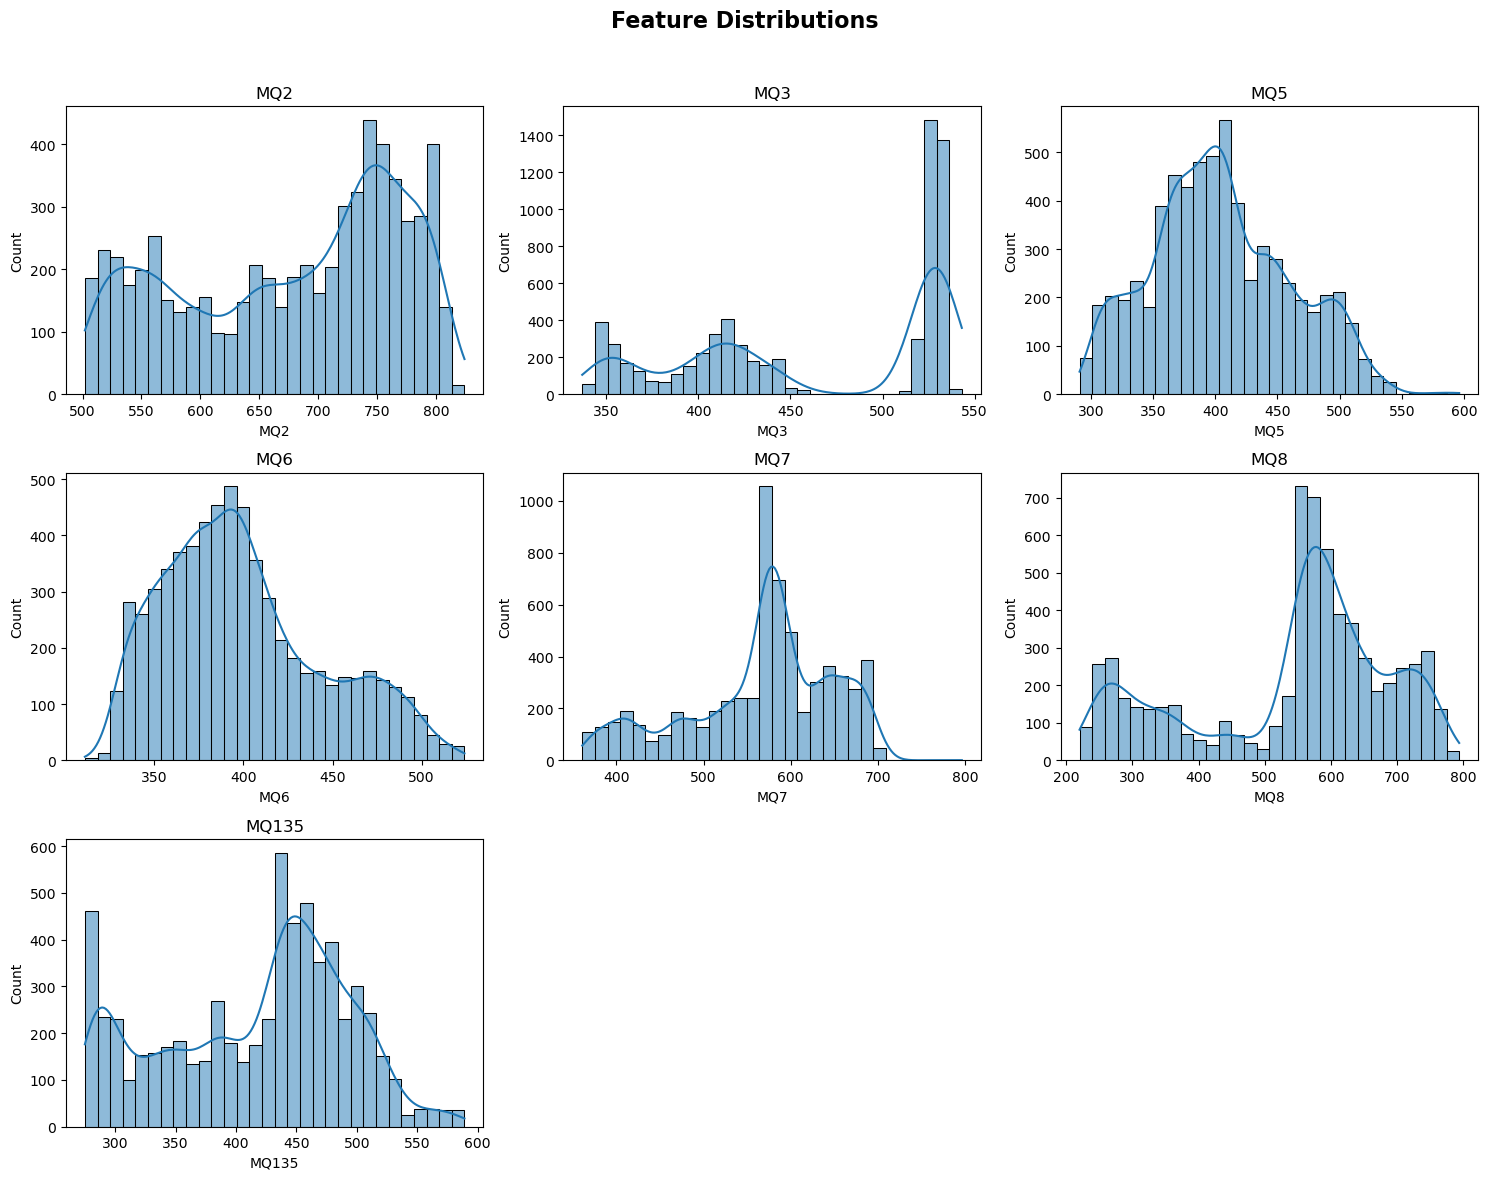

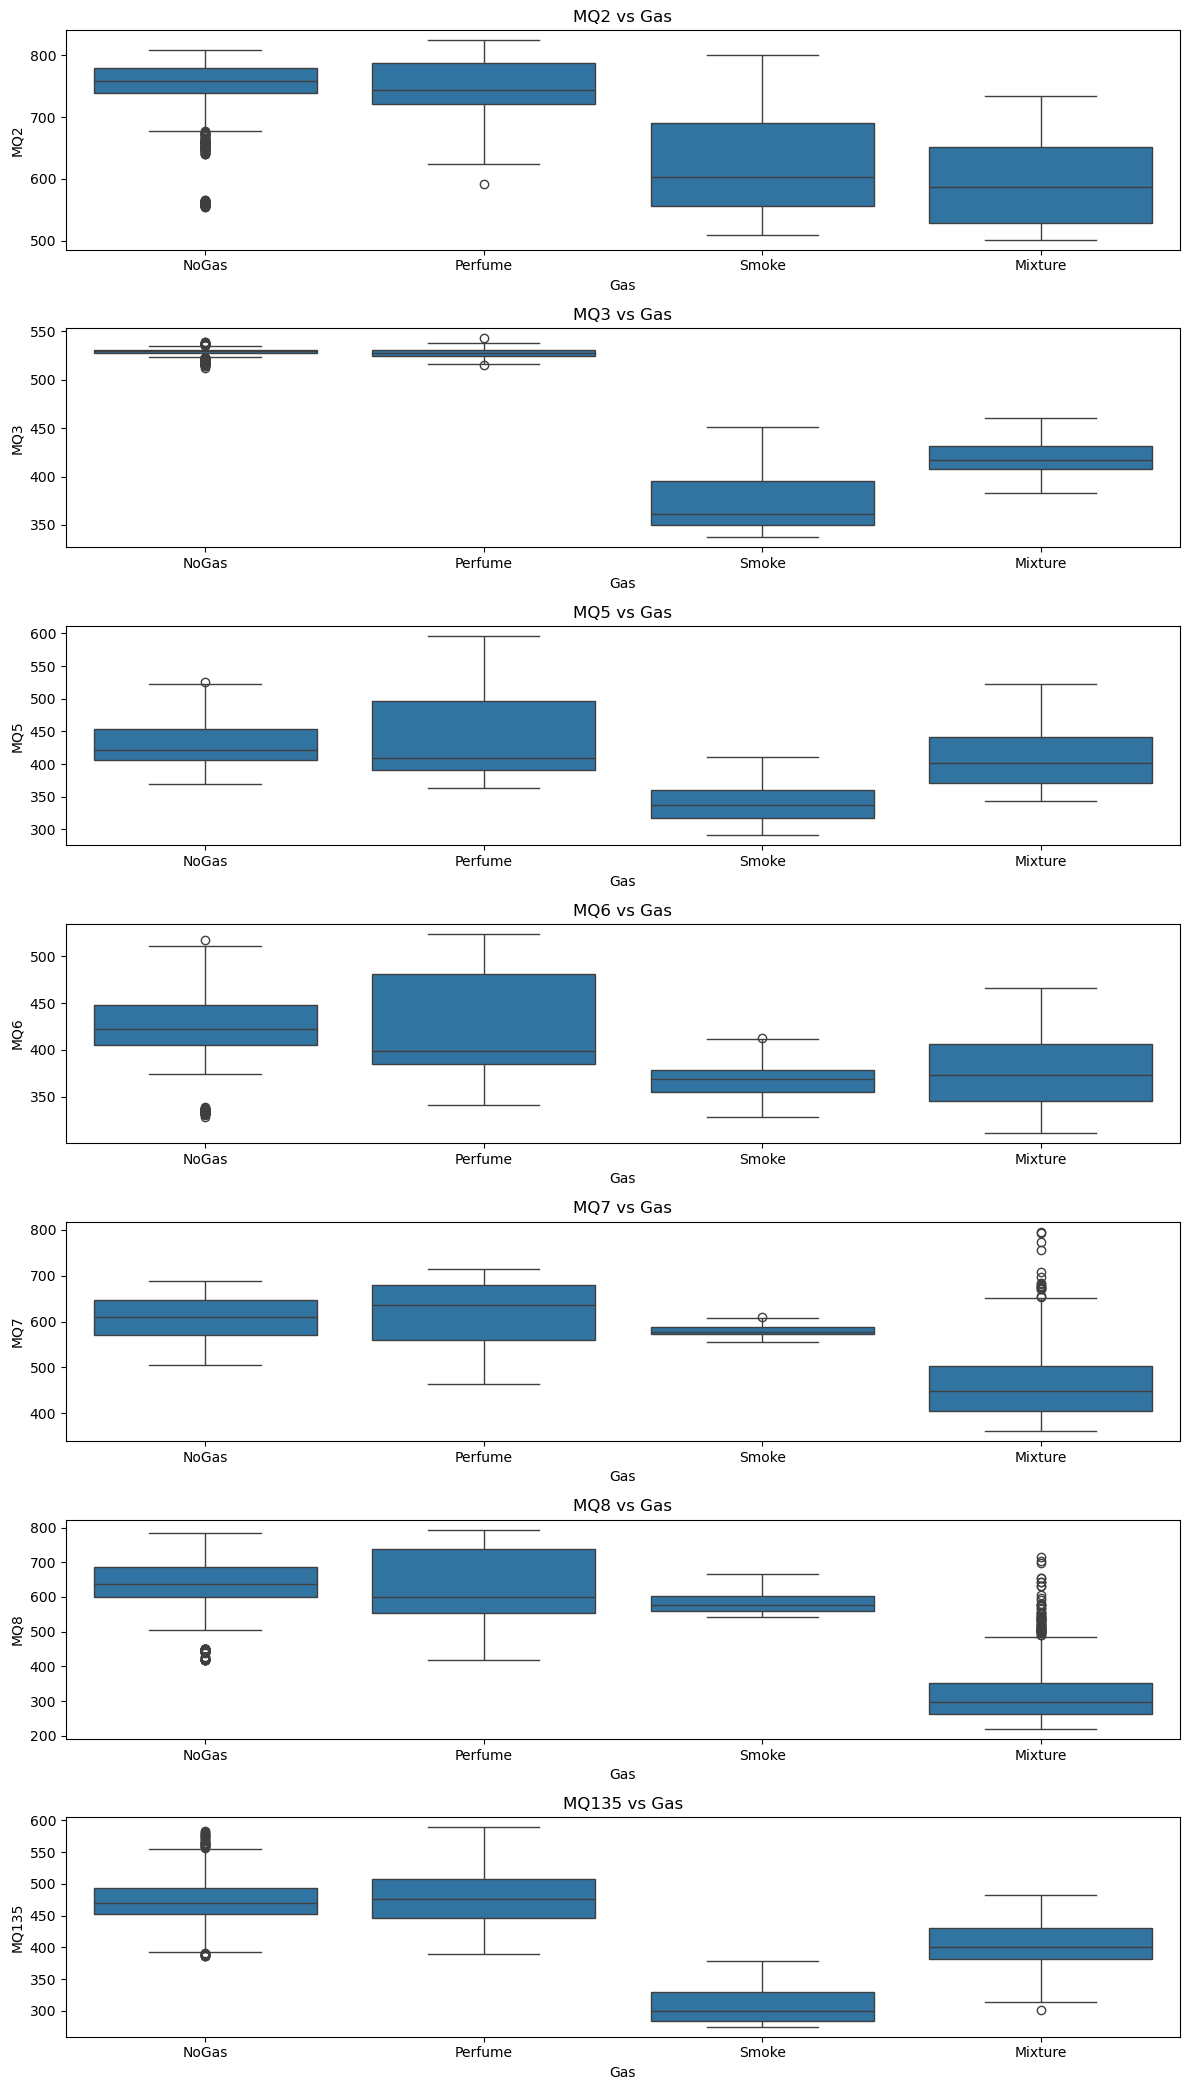

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the model, scaler, and label encoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

# Load the dataset
file_path = "PS.csv"
df = pd.read_csv(file_path)

# Drop the first column (assuming it's an index or unwanted column)
df = df.iloc[:, 1:]

# Separate features and target variable
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]   # Target variable

# Encode target labels (if they are categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save the LabelEncoder for later use
joblib.dump(label_encoder, "label_encoder.pkl")
print("[INFO] LabelEncoder saved as 'label_encoder.pkl'")

# Apply StandardScaler (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the StandardScaler
joblib.dump(scaler, "scaler.pkl")
print("[INFO] StandardScaler saved as 'scaler.pkl'")

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model after tuning
best_rf = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# Save the trained model
joblib.dump(best_rf, "random_forest_model.pkl")
print("[INFO] RandomForest model saved as 'random_forest_model.pkl'")

# Evaluate the optimized model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------- Feature Distribution Plots ----------------
num_features = len(df.columns) - 1  # Exclude target column
num_rows = (num_features // 3) + (num_features % 3 > 0)  # Arrange in rows of 3

fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
fig.suptitle("Feature Distributions", fontsize=16, fontweight='bold')

axes = axes.flatten()
for i, col in enumerate(df.columns[:-1]):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], edgecolor='black')
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):  # Hide unused subplots
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ---------------- Box Plots ----------------
fig, axes = plt.subplots(num_features, 1, figsize=(12, num_features * 3))

for i, col in enumerate(df.columns[:-1]):
    sns.boxplot(x=df.iloc[:, -1], y=df[col], ax=axes[i])
    axes[i].set_title(f"{col} vs {df.columns[-1]}")

plt.tight_layout()
plt.show()

# ---------------- Pair Plot ----------------
sns.pairplot(df, hue=df.columns[-1], diag_kind='kde')
plt.show()

# ---------------- Correlation Heatmap ----------------
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

# ---------------- Training Examples vs Accuracy ----------------
train_sizes, train_scores, test_scores = learning_curve(best_rf, X_scaled, y_encoded, cv=5, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Accuracy", marker='o')
plt.plot(train_sizes, test_mean, label="Validation Accuracy", marker='s')

plt.xlabel("Number of Training Examples")
plt.ylabel("Accuracy")
plt.title("Training Examples vs Accuracy")
plt.legend()
plt.grid()
plt.show()

# ---------------- Training Examples vs Loss ----------------
train_loss = []
test_loss = []

for size in train_sizes:
    train_size_fraction = min(size / X_train.shape[0], 0.9)  # Ensure valid train_size
    X_subset, _, y_subset, _ = train_test_split(X_train, y_train, train_size=train_size_fraction, random_state=42)
    
    best_rf.fit(X_subset, y_subset)
    
    train_loss.append(log_loss(y_subset, best_rf.predict_proba(X_subset)))
    test_loss.append(log_loss(y_test, best_rf.predict_proba(X_test)))

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_loss, label="Training Loss", marker='o', color='red')
plt.plot(train_sizes, test_loss, label="Validation Loss", marker='s', color='orange')

plt.xlabel("Number of Training Examples")
plt.ylabel("Loss")
plt.title("Training Examples vs Loss")
plt.legend()
plt.grid()
plt.show()

# ---------------- Confusion Matrix ----------------
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
